# aLAP code
This jupyter notebook contains three approaches to approximating the solution to the Linear Assignment Problem, wherein one finds a weighted matching of some graph that minimizes/maximizes the weight sums.
 The following approaches are listed below, and can be found in the linked papers.
 1.  [Parallel aLAP](https://link.springer.com/content/pdf/10.1007%2F978-3-540-68111-3_74.pdf)
 2.  [Greedy aLAP](https://link.springer.com/content/pdf/10.1007%2F3-540-49116-3_24.pdf) (algorithm 1)
 3.  [Sequential aLAP](https://link.springer.com/content/pdf/10.1007%2F3-540-49116-3_24.pdf) (algorithm 2)

In [5]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# 1.  Parallel aLAP

In [10]:
def parallel_aLAP(cost_matrix, maximize = True):
    if not maximize:
        cost_matrix = -cost_matrix
    num_vert = cost_matrix.shape[0]
    n = 2 * num_vert
    matched = np.empty(n)*np.nan
    cv = np.zeros(n)
    qn = np.zeros(n)
    col_argmax = np.argmax(cost_matrix, axis = 0)
    row_argmax = np.argmax(cost_matrix, axis = 1)
    
    # remove full zero rows and columns (match them)
    col_z = np.count_nonzero(cost_matrix, axis = 0)
    col_z = np.arange(num_vert)[col_z == np.zeros(num_vert)] 
    row_z = np.count_nonzero(cost_matrix, axis = 1)
    row_z = np.arange(num_vert)[row_z == np.zeros(num_vert)]
    mz = min([len(row_z), len(col_z)])
    col_z = col_z[:mz]
    row_z = row_z[:mz]
    
    
    cv[:num_vert] = col_argmax + num_vert  #first half points to second, vice versa
    cv[num_vert:] = row_argmax
    cv[col_z] = row_z + num_vert
    cv[row_z + num_vert] = col_z
    cv = cv.astype(int)
    

    dom_ind = (cv[cv] == np.arange(n))
    matched[dom_ind] = cv[dom_ind] #matched indices, everywhere else nan
    qc, = np.nonzero(dom_ind) #dominating vertices
    

    while len(qc) > 0 and np.isnan(matched).any(): #loop while qc not empty, ie new matchings still being found
        
        temp = np.arange(n)[np.in1d(cv,qc)] #indices of qc in cv
        qt = temp[~np.in1d(temp, matched[qc])] #indices of unmatched verts in cv and qc
        
        qt_p = qt[qt>=num_vert]
        qt_n = qt[qt< num_vert]
        
        m_row = np.arange(num_vert)[np.isnan(matched[num_vert:])] #unmatched rows to check
        m_col = np.arange(num_vert)[np.isnan(matched[:num_vert])]  #unmatched cols
            
        col_argmax = np.argmax(cost_matrix[np.ix_(m_row, qt_n)], axis = 0)
        row_argmax = np.argmax(cost_matrix[np.ix_(qt_p - num_vert, m_col)] , axis = 1)
        
        col_argmax = m_row[col_argmax]
        row_argmax = m_col[row_argmax]
        
        cv[qt_n] = col_argmax + num_vert
        cv[qt_p] = row_argmax
        cv = cv.astype(int)
        
        dom_ind = (cv[cv[qt]] == qt)
        qt = qt[dom_ind]
        matched[qt] = cv[qt] #adding new dominating indices to matching
        matched[cv[qt]] = qt
        #mate[dom_ind] = cv[dom_ind]
        
        qn = np.zeros(n)  #store new matchings
        qn[qt] = qt
        qn[cv[qt]] = cv[qt]
        qc = qn[qn>0].astype(int)
        
    matching = matched[num_vert:]
    rows = np.arange(num_vert)[~np.isnan(matching)]
    matching = matching[~np.isnan(matching)].astype(int)
    return (rows, matching)
    

# 2.  Greedy aLAP

In [2]:
def aLAP_greedy(cost_matrix, maximize =True):
    if not maximize:
        cost_matrix=-cost_matrix
 
    n = cost_matrix.shape[0]
    M = np.zeros((n,n))
    U = cost_matrix.astype(float)

    while (~np.isnan(U)).any():
        a, b = np.unravel_index(np.nanargmax(U), (n,n))
        U[a,:] = np.nan
        U[:,b] = np.nan
        M[a, b] = 1

    
    return np.nonzero(M)

# 3.  Sequential aLAP

In [4]:
def aLAP(P, maximize=True):
    if not maximize:
        P=-P
    n = P.shape[0]
    M = np.zeros((n,n))
    U = copy(P)
    C = np.zeros((n,n))
    #R = np.zeros((n,n))
    def try_match(a, b):
        nonlocal n, M, U, C, n_init
        i, j = np.nonzero(U) 
        n_init += 1
        a_free = (M[a,:] == 0).all()
        b_free = (M[b,:] == 0).all()
        a_matched = (M[a,:] != 0).any()
        b_matched = (M[b,:] != 0).any()
        while (M[a,:] == 0).all() and (M[b,:] == 0).all() and \
                (np.count_nonzero(i == a) > 1 or np.count_nonzero(i == b) > 1):
            if (M[a,:] == 0).all() and (np.count_nonzero(i == a) > 1):
                c_ind = np.nonzero(i == a) #indices of vertices adjacent to a
                for c in j[c_ind]: # first vertex not b, assigning to c
                    if c != b:
                        if U[a,c] > U[a,b]: # checking edge weight
                            C[[a,b],[b,a]] = U[[a,b],[b,a]] # moving {a,b} from U to C
                            U[[a,b],[b,a]] = 0
                            i, j = np.nonzero(U)
                            try_match(a, c)
                            break
                        else:
                            C[[a,c],[c,a]] = U[[a,c],[c,a]] # moving {a,c} from U to C
                            U[[a,c],[c,a]] = 0
                            i, j = np.nonzero(U)
                            
            if (M[b,:] == 0).all() and (np.count_nonzero(i == b) > 1):
                d_ind = np.nonzero(i == b)
                for d in j[d_ind]:
                    if d != a:
                        if U[b,d] > U[a,b]:
                            C[[a,b],[b,a]] = U[[a,b],[b,a]] # moving {a,b} from U to C
                            U[[a,b],[b,a]] = 0
                            try_match(b,d)
                            break
                        else:
                            C[[b,d],[d,b]] = U[[b,d],[d,b]] # moving {a,c} from U to C
                            U[[b,d],[d,b]] = 0
                            i, j = np.nonzero(U)
                            
            i, j = np.nonzero(U) #reset i,j
        '''
        if (M[a,:] != 0).any() and (M[b,:] != 0).any():
            C[a,:] = 0
            C[:,a] = 0
            C[b,:] = 0
            C[:,b] = 0
            n_init += 1
            
        elif (M[a,:] != 0).any() and (M[b,:] == 0).all(): #if a is matched, b free
            #R[np.nonzero(C_a)] = C_a[np.nonzero(C_a)]
            C[a,:] = 0
            C[:,a] = 0
            ic, jc = np.nonzero(C)
            d_ind = np.nonzero(ic == b)
            for d in jc[d_ind]:
                if (M[d,:] == 0).all():
                    U[[b,d],[d,b]] = C[[b,d],[d,b]]
                    i, j = np.nonzero(U)
        
                C[[b,d],[d,b]] = 0
                    
            n_init += 1
        
        elif (M[a,:] == 0).all() and (M[b,:] != 0).any(): #if b matched, a free
            #R[np.nonzero(C_b)] = C_b[np.nonzero(C_b)]
            C[b,:] = 0
            C[:,b] = 0
            ic, jc = np.nonzero(C)
            c_ind = np.nonzero(ic == a)
            for c in jc[c_ind]:
                if (M[c,:] == 0).all():
                    U[[a,c],[c,a]] = C[[a,c],[c,a]]
                    i, j = np.nonzero(U)
                C[[a,c],[c,a]] = 0
            n_init += 1
        '''
        if (M[a,:] == 0).all() and (M[b,:] == 0).all():
            #R[np.nonzero(C_a)] = C_a[np.nonzero(C_a)]
            #R[np.nonzero(C_b)] = C_b[np.nonzero(C_b)]
            C[[a,b],[b,a]] = 0
            
            if (np.count_nonzero(i == a) == 1) and (np.count_nonzero(i == b) == 1):
                U[[a,b],[b,a]] = 0
            i, j = np.nonzero(U) #reset i,j
            M[[a,b],[b,a]] = 1
                    
            
    n_init = 0
    while (U != 0).any():
        i, j = np.nonzero(U)
        index = random.randrange(len(i))
        #index = 0
        a = i[index]
        b = j[index]
        try_match(a, b)
        
        
    #print("time try_match called: " ,n_init)
    return np.nonzero(M)
        

# Baseline Performance
To demonstrate that the algorithms (specifically the parallel implementation) are working as expected, we will compare the maximum matching on returned on a few matrices from the QAPLIB using parallel_aLAP() and linear_sum_assignment()  (LSAP) from scipy.optimize, the latter of which returns an exact solution. The algorithm guarantees a solution atleast one half of optimal.


In [3]:
from scipy.optimize import linear_sum_assignment

In [11]:
qapprob = ["chr12a","chr15a","chr15a","chr20a","chr22a", "chr25a"]
datafile = np.load("qap_probs.npz",allow_pickle=True)
lap = np.zeros(len(qapprob))
alap = np.zeros(len(qapprob))
for i, p in enumerate(qapprob):
    A = datafile[p][1]
    lap[i] = A[linear_sum_assignment(A, maximize = True)].sum()
    alap[i] = A[parallel_aLAP(A, maximize = True)].sum()
    
mat = np.zeros((len(qapprob),3))
mat[:,0] = lap
mat[:,1] = alap
mat[:,2] = alap/lap
df = pd.DataFrame(mat,columns=["Scipy", "aLAP", "Ratio (aLAP/Scipy)"])
df.insert(0,"QAP",qapprob,True)
print(df)


      QAP   Scipy    aLAP  Ratio (aLAP/Scipy)
0  chr12a  1034.0  1022.0            0.988395
1  chr15a  1293.0  1158.0            0.895592
2  chr15a  1293.0  1158.0            0.895592
3  chr20a   176.0   160.0            0.909091
4  chr22a  1354.0  1354.0            1.000000
5  chr25a  1452.0  1416.0            0.975207


# Time complexity
To further investigate the performance of both aLAP and LSAP, we will run each with simulated dense cost matrices (adjacency matrix for complete graphs) of various sizes, oberving how the algorithms perform as the number of nodes (and, consquently, edges) increases.

In [12]:
def dense_matrix(num): 
    matrix = np.zeros((num,num))
    for row in range(num):
        for col in range(num):
            matrix[row,col] = random.randrange(100)
    return matrix

In [56]:
import time
import timeit
n = [50, 100, 150, 200, 250, 300, 350,500,750, 1000, 1250, 1500,
     1750, 2000, 2250, 2500, 2750, 3000]
scipy = np.zeros(len(n))
alap = np.zeros(len(n))

for i, node in enumerate(n):
    #for j in range(reps):
    mysetup_s = '''
from scipy.optimize import linear_sum_assignment
from __main__ import  node, dense_matrix
import numpy as np
A = dense_matrix(node)'''
    mycode_s = 'linear_sum_assignment(-A)'
    scipy[i] = timeit.timeit(setup = mysetup_s, stmt = mycode_s, number = 5)/5

    mysetup_p = '''
from __main__ import  node, dense_matrix, parallel_aLAP
import numpy as np
A = dense_matrix(node)'''
    mycode_p = 'parallel_aLAP(A)'
    alap[i] = timeit.timeit(setup = mysetup_p, stmt = mycode_p, number = 5)/5
        
    #print(i)

Text(0.15, 0.8, 'R^2 = 0.9981592499025731')

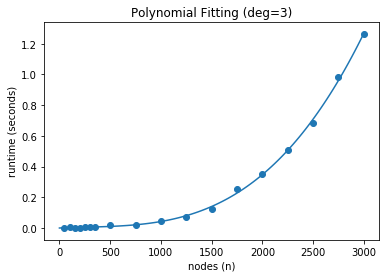

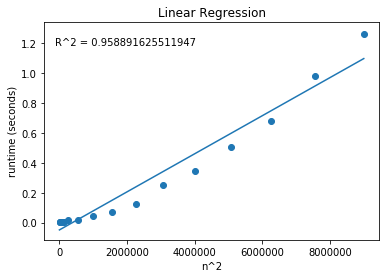

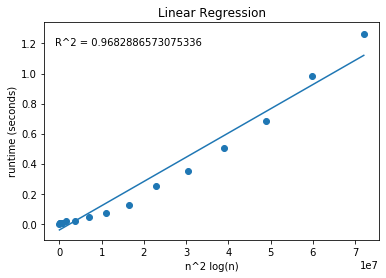

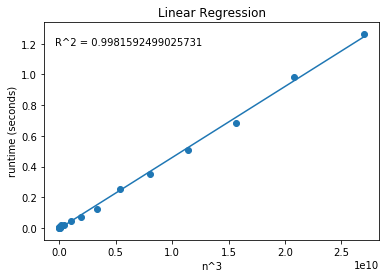

In [57]:
from scipy.stats import linregress
plt.scatter(n, alap)
# coef = np.polyfit([i**2 for i in n], alap[:,0], 2)
coef = np.polyfit(n, alap, 3)
y_new = np.poly1d(coef)
plt.plot(np.linspace(0,max(n),100), y_new(np.linspace(0,max(n),100)))
plt.title("Polynomial Fitting (deg=3)")
plt.ylabel('runtime (seconds)')
plt.xlabel('nodes (n)')

plt.figure()
plt.scatter([(i**2) for i in n], alap)
# coef = np.polyfit([(i**2) for i in n], alap[:,0], 1)
# y_new = np.poly1d(coef)
res = linregress([i**2 for i in n], alap)
y_new = np.poly1d([res[0], res[1]])
m = np.max([(i**2) for i in n])
plt.plot(np.linspace(0,m,100), y_new(np.linspace(0,m,100)))
plt.title("Linear Regression")
plt.ylabel('runtime (seconds)')
plt.xlabel('n^2')
plt.figtext(0.15,0.80, 'R^2 = '+ str(res[2]**2))

plt.figure()
plt.scatter([(i**2)*np.log(i) for i in n], alap)
res = linregress([(i**2)*np.log(i) for i in n], alap)
y_new = np.poly1d([res[0], res[1]])
m = np.max([(i**2)*np.log(i) for i in n])
plt.plot(np.linspace(0,m,100), y_new(np.linspace(0,m,100)))
plt.title("Linear Regression")
plt.ylabel('runtime (seconds)')
plt.xlabel('n^2 log(n)')
plt.figtext(0.15,0.80, 'R^2 = '+ str(res[2]**2))

plt.figure()
plt.scatter([(i**3) for i in n], alap)
res = linregress([(i**3) for i in n], alap)
y_new = np.poly1d([res[0], res[1]])
m = np.max([(i**3) for i in n])
plt.plot(np.linspace(0,m,100), y_new(np.linspace(0,m,100)))
plt.title("Linear Regression")
plt.ylabel('runtime (seconds)')
plt.xlabel('n^3')
plt.figtext(0.15,0.80, 'R^2 = '+ str(res[2]**2))

Text(0.15, 0.8, 'R^2 = 0.989762251642438')

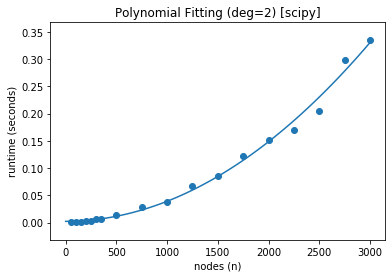

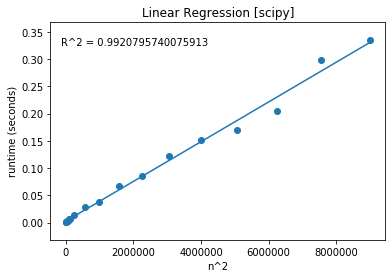

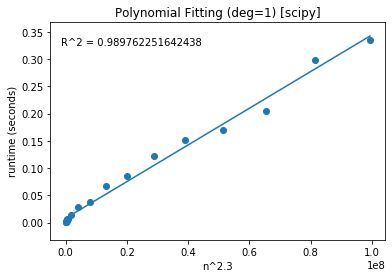

In [58]:

plt.scatter(n, scipy)
# coef = np.polyfit([i**2 for i in n], alap[:,0], 2)
coef = np.polyfit(n, scipy, 2)
y_new = np.poly1d(coef)
plt.plot(np.linspace(0,max(n),100), y_new(np.linspace(0,max(n),100)))
plt.title("Polynomial Fitting (deg=2) [scipy]")
plt.ylabel('runtime (seconds)')
plt.xlabel('nodes (n)')

# plt.figure()
# plt.scatter([(i**2)*np.log(i) for i in n], scipy[:,0])
# coef = np.polyfit([(i**2)*np.log(i) for i in n], scipy[:,0], 1)
# y_new = np.poly1d(coef)
# m = np.max([(i**2)*np.log(i) for i in n])
# plt.plot(np.linspace(0,m,100), y_new(np.linspace(0,m,100)))
# print(coef)

plt.figure()
plt.scatter([(i**2) for i in n], scipy)
# coef = np.polyfit([i**2 for i in n], scipy[:,0], 1)
# y_new = np.poly1d(coef)
res = linregress([i**2 for i in n], scipy)
y_new = np.poly1d([res[0], res[1]])
m = np.max([(i**2) for i in n])
plt.plot(np.linspace(0,m,100), y_new(np.linspace(0,m,100)))
plt.title("Linear Regression [scipy]")
plt.ylabel('runtime (seconds)')
plt.xlabel('n^2')
plt.figtext(0.15,0.80, 'R^2 = '+ str(res[2]**2))

plt.figure()
plt.scatter([(i**2.3) for i in n], scipy)
res = linregress([i**2.3 for i in n], scipy)
y_new = np.poly1d([res[0], res[1]])
m = np.max([(i**2.3) for i in n])
plt.plot(np.linspace(0,m,100), y_new(np.linspace(0,m,100)))
plt.title("Polynomial Fitting (deg=1) [scipy]")
plt.ylabel('runtime (seconds)')
plt.xlabel('n^2.3')
plt.figtext(0.15,0.80, 'R^2 = '+ str(res[2]**2))


As we can see, performance of LSAP actually scales better as the size of the cost matrix increases

# Runtime as a function of cost matrix density (edgeset size)

In [64]:
def sparse_matrix(n,m): # n = number of nodes, m = number of edges
    m = int(m)
    matrix = np.zeros((n,n))
    rows = random.sample(range(n**2), m)
    for i in range(n):
        for j in range(n):
            if (i*n + j) in rows:
                matrix[i,j] = random.randrange(100)
    return matrix


Text(0, 0.5, 'runtime (sec)')

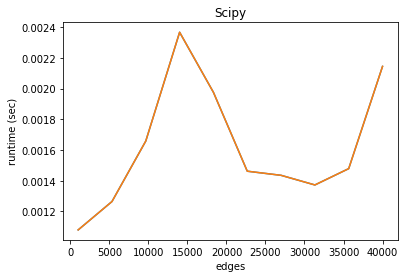

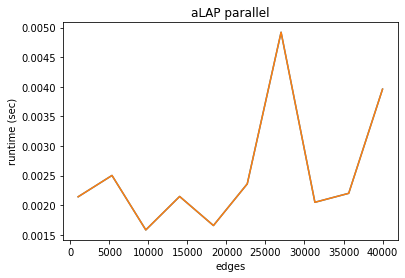

In [63]:
n = 200
m = np.linspace(1000, n**2, 10)
scipy_sc = np.zeros((len(m), 2))
alap_sc = np.zeros((len(m), 2))


for i, edge in enumerate(m):
    mysetup_s = '''
from scipy.optimize import linear_sum_assignment
from __main__ import  edge, sparse_matrix
import numpy as np
n = 200
A = sparse_matrix(n, edge)'''
    mycode_s = 'linear_sum_assignment(-A)'
    scipy_sc[i] = timeit.timeit(setup = mysetup_s, stmt = mycode_s, number = 5)/5

    mysetup_p = '''
from __main__ import  edge, sparse_matrix, parallel_aLAP
import numpy as np
n = 200
A = sparse_matrix(n, edge)'''
    mycode_p = 'parallel_aLAP(A)'
    alap_sc[i] = timeit.timeit(setup = mysetup_p, stmt = mycode_p, number = 5)/5
        
    #print(i)
plt.plot(m, scipy_sc)
plt.xlabel('edges')
plt.ylabel('runtime (sec)')
plt.title('Scipy')
plt. figure()
plt.plot(m, alap_sc)
plt.title('aLAP parallel')
plt.xlabel('edges')
plt.ylabel('runtime (sec)')



From the figures above, neither algorithm has traceble trends in runtime due to cost matrix density. This is likely due to the graph representation as an adjacency matrix. The approximation algorithms for LAP depend on the fact that the graph be represented as a group of edges with associated weight, with the time complexity dependent on the number of weighted edges. However, by using an adjacency matrix, we are essentially operating on a complete graph, with "no edges" treated as "edges with weight zero". For this reason, sparcity does not effect runtime or complexity of aLAP, since the algorithm will check over each possible existing edge atleast once. Additionally, as FAQ is dependent on matrix operations, it is necessary that our linear assignment solver take in cost functions in the form of a matrix. For these reasons, I don't think it is worth further investigating aLAP as a method to speed up FAQ.